In [1]:
import pandas as pd
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.vector_ar.vecm as vm
from itertools import combinations
from statsmodels.tsa.stattools import coint, adfuller
import seaborn as sns

In [2]:
# add algo_testing to path
sys.path.append(os.path.join(sys.path[3], 'algo_testing'))

In [3]:
from helpers.read_eco_data import preprocess

In [4]:
# read esg_data
esg_df = preprocess('../esg_data/esg_data.json')
esg_df = esg_df.loc[esg_df['eco_score'] > 0]
esg_df = esg_df.reset_index(drop=True)

In [5]:
# cleaned stocks contain only stocks that have esg data
cleaned_stocks = pd.read_csv('../esg_data/cleaned_stocks.csv')

In [6]:
cleaned_stocks.keys()

Index(['date', '3MINDIA_price', 'ADANIPORTS_price', 'ADANIPOWER_price',
       'AEGISCHEM_price', 'ALLCARGO_price', 'AMARAJABAT_price',
       'ANANTRAJ_price', 'APOLLOTYRE_price', 'ASAHIINDIA_price',
       ...
       'TATAINVEST_price', 'TATAMOTORS_price', 'TATAPOWER_price', 'TTML_price',
       'TECHM_price', 'TEXRAIL_price', 'FEDERALBNK_price', 'KTKBANK_price',
       'KARURVYSYA_price', 'THERMAX_price'],
      dtype='object', length=202)

In [7]:
import multiprocessing as mp
from matplotlib.pyplot import figure

In [8]:
from numba import njit, cuda 

In [9]:
def find_cointegrated_pairs(data, coint):
    n = data.shape[1]-1 # number of stocks
    
    score_matrix = np.zeros((n,n))
    pvalue_matrix = np.ones((n,n))
    stocks = data.columns[1:]
    
    pairs = []
    for i in range(n):
        for j in range(i):
            assert i != j
            assert stocks[i] != stocks[j]
            
            s1 = data[stocks[i]]
            s2 = data[stocks[j]]
            result = coint(s1,s2)
            score = result[0] 
            pvalue = result[1]
            score_matrix[i,j] = score_matrix[j,i] = score
            pvalue_matrix[i,j] =  pvalue_matrix[j,i] = pvalue
            if (pvalue < 0.05 and pvalue!=0):                #cutoff
                pairs.append((pvalue, (stocks[i], stocks[j])))
                
    return score_matrix, pvalue_matrix, pairs

<Axes: >

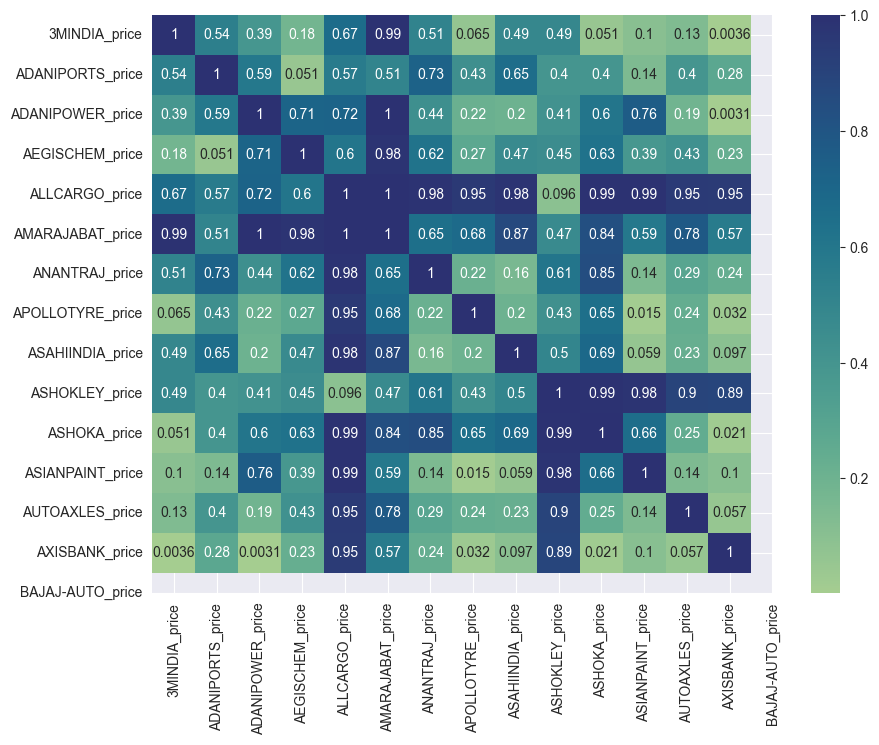

In [66]:
# get the first 100 columns of cleaned_stocks

END = 15

scores, pvalues, pairs = find_cointegrated_pairs(cleaned_stocks.iloc[:, :END], coint)

figure(figsize=(10, 7.5), dpi=100)
sns.heatmap(pvalues, xticklabels = cleaned_stocks.columns[1:END], yticklabels = cleaned_stocks.columns[1:END],
        cmap = 'crest',  annot = True)

In [67]:
pairs

[(0.014553344179010327, ('AUTOAXLES_price', 'ASAHIINDIA_price')),
 (0.0035558210595060297, ('BAJAJ-AUTO_price', 'ADANIPORTS_price')),
 (0.0031431295159772116, ('BAJAJ-AUTO_price', 'AEGISCHEM_price')),
 (0.03210602040586319, ('BAJAJ-AUTO_price', 'ASAHIINDIA_price')),
 (0.02109521761019569, ('BAJAJ-AUTO_price', 'ASIANPAINT_price'))]

In [68]:
min(pairs)

In [69]:
import statsmodels.api as sm

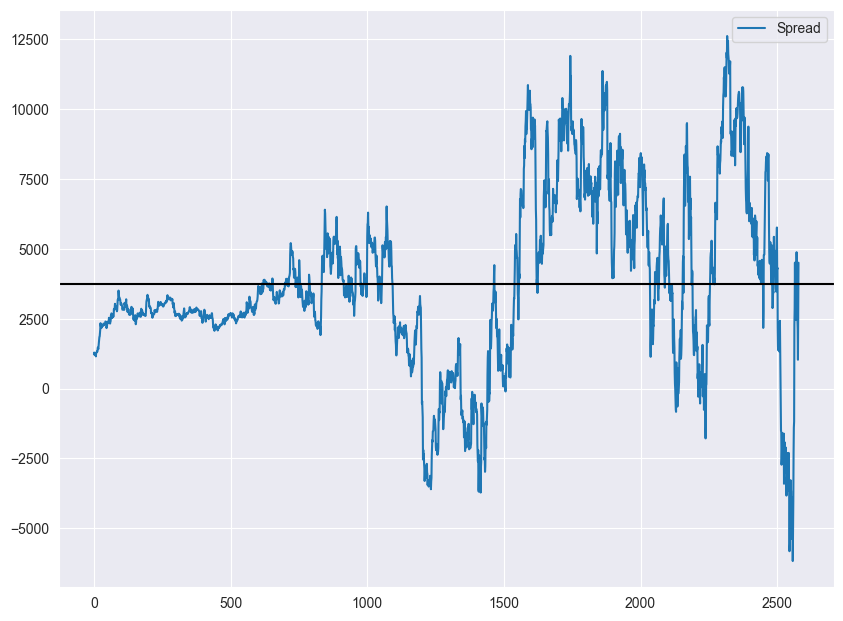

In [72]:
S1= cleaned_stocks['AEGISCHEM_price']
S2= cleaned_stocks['3MINDIA_price']

S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1['AEGISCHEM_price']
b = results.params['AEGISCHEM_price']

spread = S2 - b * S1
spread.plot(figsize=(10, 7.5))
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread']);

In [73]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

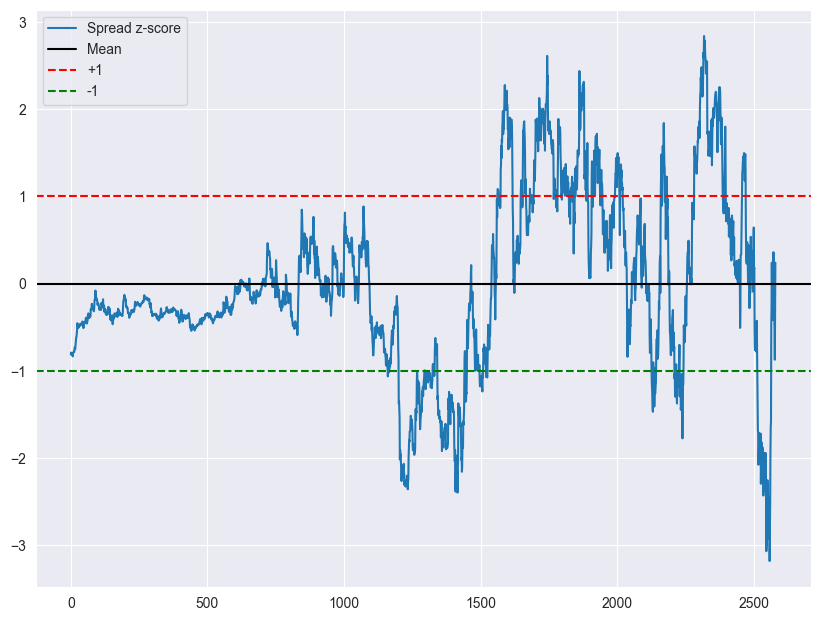

In [74]:
zscore(spread).plot(figsize=(10, 7.5))
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1']);

In [75]:
#Dataframe for trading signals
def signal_pairs(x,y):
  signals = pd.DataFrame()
  signals['asset1'] = x 
  signals['asset2'] = y

  #Calculating Z score of spread and defining upper and lower threshhold
  ratio = signals['asset1']/signals['asset2']
  signals['z'] = zscore(ratio)
  signals['z upper limit'] = np.mean(signals['z']) + np.std(signals['z'])
  signals['z lower limit'] = np.mean(signals['z']) - np.std(signals['z'])
  signals['signals1'] = 0
  signals['signals1'] = np.select([signals['z'] >signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)

  signals['positions1'] = signals['signals1'].diff()
  signals['signals2'] = -signals['signals1']
  signals['positions2'] = signals['signals2'].diff()

  return signals

In [76]:
signals = signal_pairs(S1,S2)

In [77]:
signals

,asset1,asset2,z,z upper limit,z lower limit,signals1,positions1,signals2,positions2
0,28.80,3249.10,-0.119602,1.0,-1.0,0,NaN,0,NaN
1,28.60,3295.60,-0.170238,1.0,-1.0,0,0.0,0,0.0
2,28.55,3225.00,-0.122677,1.0,-1.0,0,0.0,0,0.0
3,28.80,3231.05,-0.106104,1.0,-1.0,0,0.0,0,0.0
4,28.72,3255.70,-0.131199,1.0,-1.0,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...
2574,368.05,28280.85,1.011691,1.0,-1.0,-1,-1.0,1,1.0
2575,382.00,28922.55,1.064459,1.0,-1.0,-1,0.0,1,0.0
2576,376.30,27407.55,1.206782,1.0,-1.0,-1,0.0,1,0.0
2577,364.55,28680.35,0.929009,1.0,-1.0,0,1.0,0,-1.0


In [78]:
def plot_signals(signals):
    # visualize trading signals and position
    fig = plt.figure(figsize=(14, 6))
    bx = fig.add_subplot(111)
    bx2 = bx.twinx()
    #plot two different assets
    l1, = bx.plot(signals['asset1'], c='#4abdac')
    u1, = bx.plot(signals['asset1'][signals['positions1'] == 1], lw=0, marker='^', markersize=8, c='g', alpha=0.7)

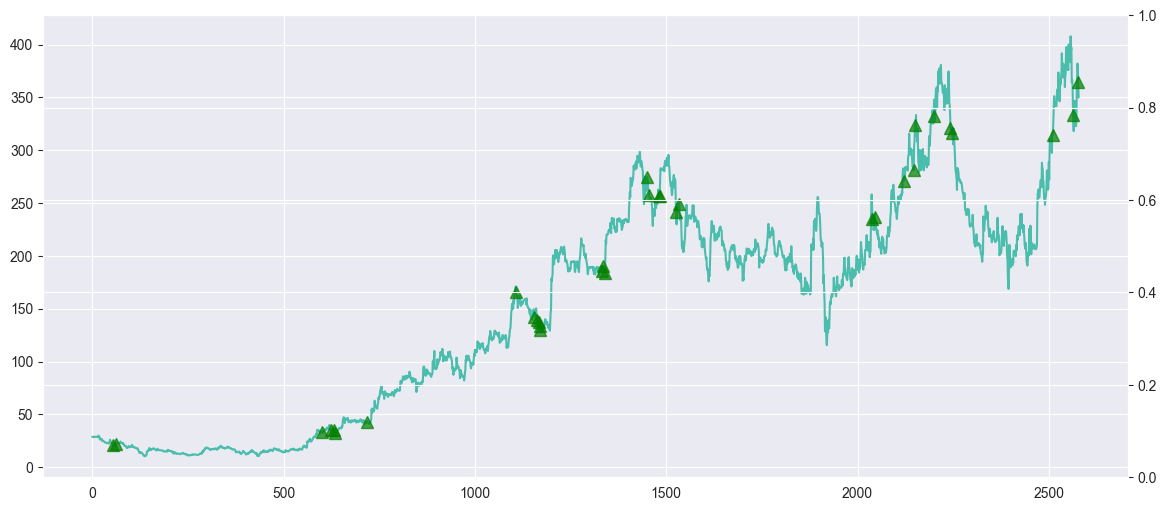

In [79]:
plot_signals(signals)

In [80]:
def pnl_calculation(signals):

  initial_capital = 100000

  # shares to buy for each position 
  positions1 = initial_capital// max(signals['asset1']) 
  positions2 = initial_capital// max(signals['asset2'])

  #pnl for the 1st asset
  portfolio = pd.DataFrame()
  portfolio['asset1'] = signals['asset1']
  portfolio['holdings1'] = signals['positions1'].cumsum() * signals['asset1'] * positions1
  portfolio['cash1'] = initial_capital - (signals['positions1'] * signals['asset1'] * positions1).cumsum()
  portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
  portfolio['return1'] = portfolio['total asset1'].pct_change()
  portfolio['positions1'] = signals['positions1']

  # pnl for the 2nd asset
  portfolio['asset2'] = signals['asset2']
  portfolio['holdings2'] = signals['positions2'].cumsum() * signals['asset2'] * positions2
  portfolio['cash2'] = initial_capital - (signals['positions2'] * signals['asset2'] * positions2).cumsum()
  portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
  portfolio['return2'] = portfolio['total asset2'].pct_change()
  portfolio['positions2'] = signals['positions2']

  # total pnl and z-score
  portfolio['z'] = signals['z']
  portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
  portfolio['z upper limit'] = signals['z upper limit']
  portfolio['z lower limit'] = signals['z lower limit']
  portfolio = portfolio.dropna()

  return portfolio

In [81]:
portfolio = pnl_calculation(signals)
portfolio.head()

C:\Users\esnd1\AppData\Local\Temp\ipykernel_21372\622338178.py:15: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  portfolio['return1'] = portfolio['total asset1'].pct_change()
C:\Users\esnd1\AppData\Local\Temp\ipykernel_21372\622338178.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  portfolio['return2'] = portfolio['total asset2'].pct_change()


,asset1,holdings1,cash1,total asset1,return1,positions1,asset2,holdings2,cash2,total asset2,return2,positions2,z,total asset,z upper limit,z lower limit
2,28.55,0.0,100000.0,100000.0,0.0,0.0,3225.00,0.0,100000.0,100000.0,0.0,0.0,-0.122677,200000.0,1.0,-1.0
3,28.80,0.0,100000.0,100000.0,0.0,0.0,3231.05,0.0,100000.0,100000.0,0.0,0.0,-0.106104,200000.0,1.0,-1.0
4,28.72,0.0,100000.0,100000.0,0.0,0.0,3255.70,0.0,100000.0,100000.0,0.0,0.0,-0.131199,200000.0,1.0,-1.0
5,28.93,0.0,100000.0,100000.0,0.0,0.0,3289.80,0.0,100000.0,100000.0,0.0,0.0,-0.138724,200000.0,1.0,-1.0
6,28.81,0.0,100000.0,100000.0,0.0,0.0,3230.00,0.0,100000.0,100000.0,0.0,0.0,-0.104470,200000.0,1.0,-1.0


In [82]:
# plots total asset value at each time step
def plot_portfolio_value(portfolio):
  
  # plot the asset value change of the portfolio and pnl along with z-score
  fig = plt.figure(figsize=(14,6),)
  ax = fig.add_subplot(111)
  ax2 = ax.twinx()
  l1, = ax.plot(portfolio['total asset'], c='g')
  l2, = ax2.plot(portfolio['z'], c='black', alpha=0.3)
  b = ax2.fill_between(portfolio.index,portfolio['z upper limit'], portfolio['z lower limit'], alpha=0.2,color='#ffb48f')
  ax.set_ylabel('Asset Value')
  ax2.set_ylabel('Z Statistics',rotation=270)
  ax.yaxis.labelpad=15
  ax2.yaxis.labelpad=15
  ax.set_xlabel('Date')
  ax.xaxis.labelpad=15
  plt.title('Portfolio Performance with Profit and Loss')
  plt.legend([l2,b,l1],['Z Statistics', 'z Score between upper limit and lower limit','Total Portfolio Value'],loc='upper left');

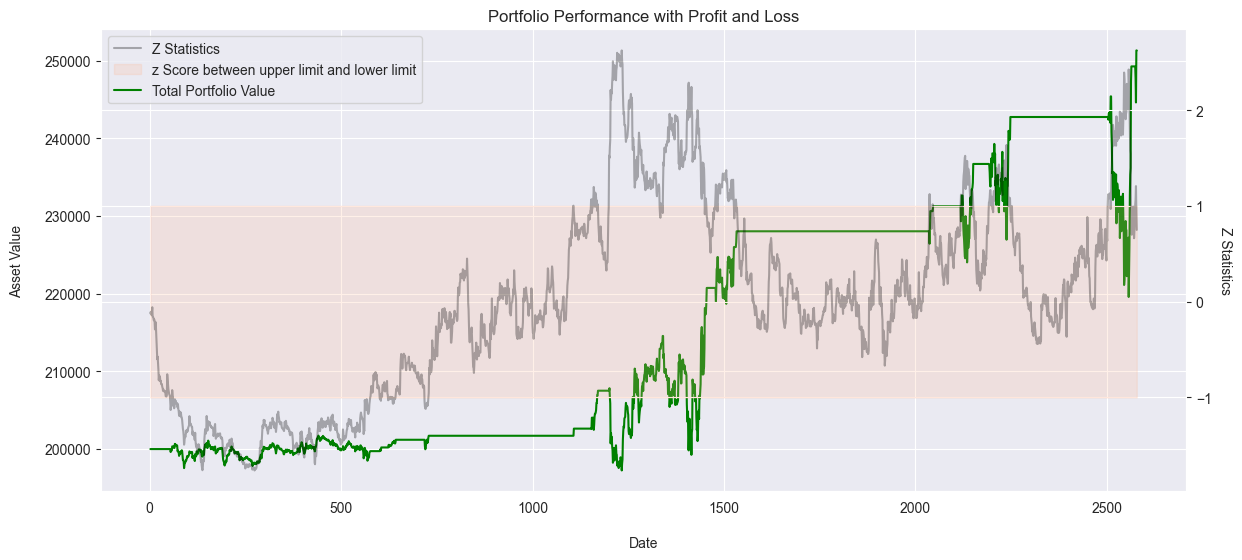

In [83]:
plot_portfolio_value(portfolio)

In [84]:
def calculate_cagr(portfolio):
    # calculate CAGR
    final_portfolio = portfolio['total asset'].iloc[-1]
    initial_portfolio = portfolio['total asset'].iloc[0]
    delta = (portfolio.index[-1] - portfolio.index[0])
    print('Number of days = ', delta)
    YEAR_DAYS = 365
    returns = (final_portfolio / initial_portfolio) ** (YEAR_DAYS / delta) - 1
    return returns

In [85]:
print('CAGR = {:.3f}%'.format(calculate_cagr(portfolio) * 100))

Number of days =  2576
CAGR = 3.290%
